#### **Inflation Forecasting**

**Author: Fabián Villarreal Sosa**

Notebook to compare between machine learning models and classic econometric models to forecast inflation in Ecuador.

References: 
* Araujo, G. S., & Gaglianone, W. P. (2020). Machine learning methods for inflation forecasting in Brazil: New contenders versus classical models. *CEMLA*.
[Link](https://www.cemla.org/actividades/2020-final/2020-10-xxv-meeting-cbrn/Session%202/3.%20Machine_Learning...%20Wagner%20Piazza.pdf)

In [557]:
# Librerias
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import mplcursors
import seaborn as sns

import datetime as dt

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
import statsmodels.formula.api as sm

from xgboost import XGBRegressor, plot_importance

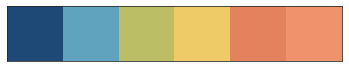

In [558]:
# Graphics style
sns.set_style('white')
csfont = {'fontname':'Calibri'}

# Color palette
my_palette = ['#1E4976', '#5FA3BF', '#BBBE64', '#EFCB68', '#E5825E', '#EF936C']
sns.palplot(sns.color_palette(my_palette))

# Define palette
sns.set_palette(my_palette)

In [559]:
# Change directory
os.chdir('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Data')
os.getcwd()

'C:\\Users\\fvill\\Dropbox\\DS_ML_Projects\\Inflation_Forecasting\\Data'

In [560]:
# Data
df = pd.read_csv('final_dataframe_ipc.csv')

print(df.shape)
df.head()

(213, 50)


,date,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,...,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,pos_sucre,res_internacional,ipp,ipcons
0,2004-01-01,65.95,102.870594,103.509825,96.533766,106.319005,101.967123,77.748841,74.175894,2648.634643,...,4.150500,868.32,337.70,10.43,25.41,-1.44,NaN,1240.42,61.89,141.53
1,2004-02-01,66.40,106.416805,104.178680,97.211906,107.276700,103.401263,78.399193,70.401638,2674.554642,...,4.084211,844.86,334.41,2.93,25.39,-1.02,NaN,1206.57,63.92,144.85
2,2004-03-01,66.87,107.844485,105.793566,97.579271,106.919136,104.142381,78.893621,82.953463,2560.377642,...,3.826522,752.60,357.93,47.35,25.39,-1.65,NaN,1181.62,65.59,149.13
3,2004-04-01,67.30,108.420300,105.424685,97.296079,107.215493,104.176860,79.220693,79.764433,2574.293642,...,4.347619,867.16,328.21,17.29,24.90,-1.50,NaN,1236.06,65.24,152.82
4,2004-05-01,66.98,106.551494,105.378734,97.854182,107.619727,103.982039,79.412239,76.053673,2665.753688,...,4.715500,866.90,332.21,10.23,25.19,-1.55,NaN,1232.98,64.59,157.37


##### **Cleaning and data mining**

* The cleaning and data mining process was carried out in the 'Datos.ipynb' script.

In [561]:
df['date'] = pd.to_datetime(df['date'])

In [562]:
# Missing values
cols_nans = df.columns[df.isna().any()]
cols_nans

Index(['din_elec', 'pos_sucre'], dtype='object')

In [563]:
# Remove variables with missing values
df.drop(cols_nans, axis = 1, inplace = True)

##### **Data exploration**

* We explore the behavior of the CPI along with other variables and their correlation.

In [564]:
df.describe()

,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,caja_bce,...,CPI_US,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,res_internacional,ipp,ipcons
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,...,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,90.573146,193.121124,138.374738,111.247542,138.225293,140.837605,132.156037,131.998480,12182.943293,424.916925,...,228.406892,2.868580,2702.862160,873.301596,23.023521,34.552958,1.674366,3666.575915,90.606761,220.572207
std,14.291268,39.593242,13.498283,6.453254,11.458776,15.540000,29.868151,31.084250,8092.539372,223.475144,...,21.720889,1.138089,1149.419615,418.989087,65.374594,7.583121,8.880850,1295.992576,13.521277,28.285939
min,65.950000,102.870594,103.509825,96.533766,106.319005,101.967123,77.748841,70.401638,2560.377642,57.840000,...,186.300000,0.623636,469.200000,328.210000,0.140000,24.430000,-26.680000,1181.620000,61.890000,141.530000
25%,78.600000,168.730776,130.201817,106.626623,133.742724,132.520250,101.110747,101.926132,4562.729915,220.795579,...,212.705000,1.978095,1852.230000,494.930000,8.380000,26.260000,-0.430000,2790.040000,81.990000,211.090000
50%,94.580000,213.391527,144.580523,113.170036,143.549848,148.878440,147.626107,142.950634,9574.567546,440.924196,...,231.249000,2.698636,2619.690000,793.200000,23.660000,39.170000,0.040000,3668.880000,96.020000,235.040000
75%,104.970000,225.428375,148.892973,116.090462,146.544474,152.828103,157.251953,157.139249,20640.197470,570.522437,...,244.006000,3.814091,3237.410000,1137.640000,25.290000,40.480000,3.240000,4274.630000,102.190000,238.620000
max,106.560000,233.698072,154.318022,120.993600,150.434876,157.286879,168.943404,182.962177,28797.135580,1108.461104,...,274.214000,5.110000,6065.240000,1960.070000,960.530000,45.240000,55.930000,7195.650000,104.800000,267.670000


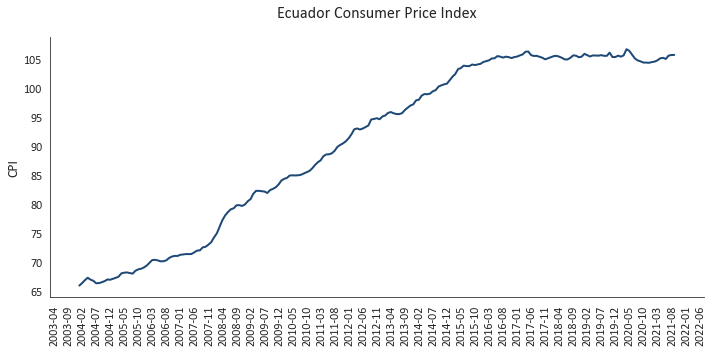

In [565]:
# Graph: IPC
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = 'ipc',
              linewidth = 2,
              color = my_palette[0],
              ax = ax)
plt.title('Ecuador Consumer Price Index', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_Ecuador_CPI.png', dpi = 500)

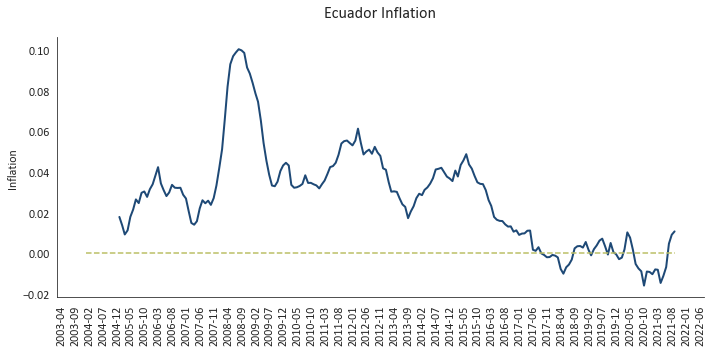

In [566]:
# Graph: Inflation
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = df['ipc'].pct_change(periods = 12), # Ecuador interannual inflation
              linewidth = 2,
              color = my_palette[0],
              ax = ax)
sns.lineplot(data = df, x = 'date', y = 0, color = my_palette[2], linestyle = '--')
plt.title('Ecuador Inflation', fontsize = 16, pad = 20, **csfont)
plt.ylabel('Inflation', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_Ecuador_Inflation.png', dpi = 500)

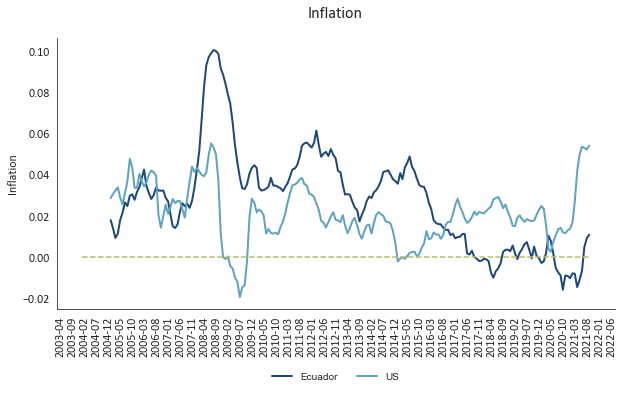

In [567]:
# Graph: Inflation (Ecuador vs US)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = df['ipc'].pct_change(periods = 12), # Ecuador interannual inflation
              linewidth = 2,
              color = my_palette[0],
              label = 'Ecuador',
              ax = ax)
sns.lineplot(data = df,
              x = 'date',
              y = df['CPI_US'].pct_change(periods = 12), # US interannual inflation
              linewidth = 2,
              color = my_palette[1],
              label = 'US',
              ax = ax)
sns.lineplot(data = df, x = 'date', y = 0, color = my_palette[2], linestyle = '--')
plt.title('Inflation', fontsize = 16, pad = 20, **csfont)
plt.ylabel('Inflation', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

sns.despine()
plt.gcf().set_size_inches(10, 5);

In [568]:
# Correlation matrix
num_cols = df.drop(['date'], axis = 1).columns
df[num_cols].corr().head()

,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,caja_bce,...,CPI_US,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,res_internacional,ipp,ipcons
ipc,1.000000,0.931881,0.906384,0.823421,0.846815,0.902907,0.954765,0.916484,0.902956,0.706139,...,0.951851,-0.863967,0.358788,0.437306,0.080685,0.861823,-0.181672,0.480010,0.979800,0.924084
ind_man,0.931881,1.000000,0.990449,0.941728,0.968617,0.994696,0.975246,0.945258,0.737803,0.768525,...,0.883488,-0.803591,0.446005,0.535261,0.100180,0.854029,-0.093874,0.597440,0.969198,0.959074
ind_com,0.906384,0.990449,1.000000,0.948346,0.978729,0.995589,0.954859,0.927928,0.712581,0.751213,...,0.868670,-0.768025,0.468716,0.522636,0.106233,0.817443,-0.069837,0.612732,0.948806,0.952131
ind_con,0.823421,0.941728,0.948346,1.000000,0.931697,0.961438,0.901619,0.880248,0.557359,0.718162,...,0.731207,-0.681585,0.491485,0.379980,0.112721,0.803066,-0.062427,0.595684,0.875490,0.879912
ind_ser,0.846815,0.968617,0.978729,0.931697,1.000000,0.984252,0.904280,0.877928,0.626877,0.735449,...,0.819815,-0.732520,0.485287,0.569654,0.108257,0.749825,-0.008948,0.642339,0.913933,0.948616


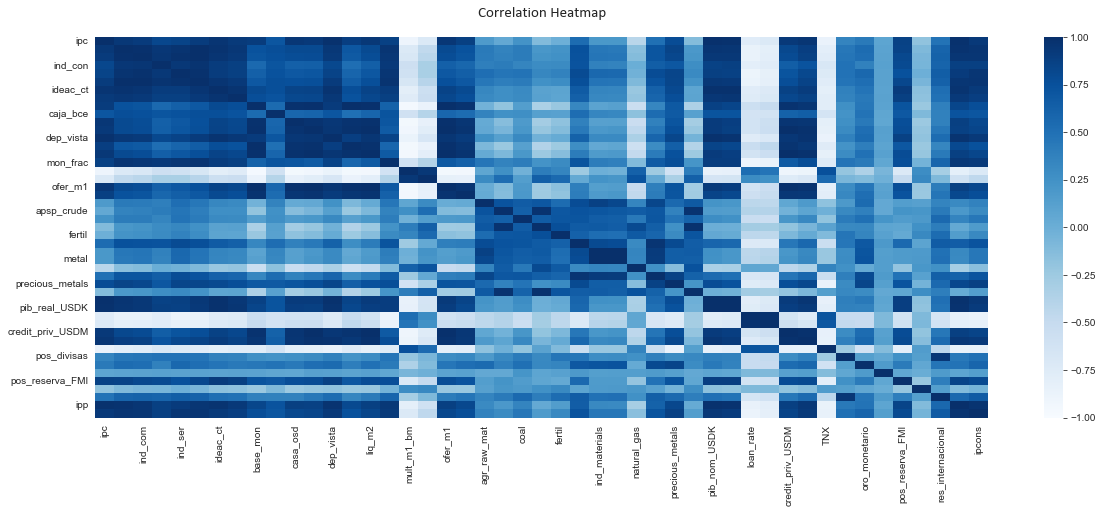

In [569]:
# Heatmap: Correlation matrix
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.heatmap(df[num_cols].corr(),
            vmin = -1, vmax = 1,
            cmap = 'Blues')
plt.title('Correlation Heatmap', fontsize = 15, pad = 20, **csfont)
plt.gcf().set_size_inches(20, 7);

In [570]:
# Define function for scatter plots
def scatter_plot(data, x_var, y_var, color, title, x_label, y_label):
  
  fig, ax = plt.subplots(nrows = 1, ncols = 1)
  sns.scatterplot(data = data,
                  x = x_var,
                  y = y_var,
                  alpha = 0.4,
                  color = color)
  plt.title(f'{title}', fontsize = 16, pad = 20, **csfont)
  plt.xlabel(f'{x_label}', fontsize = 12, labelpad = 15, **csfont)
  plt.xticks(fontsize = 12, rotation = 90, **csfont)
  plt.ylabel(f'{y_label}', fontsize = 12, **csfont)
  plt.yticks(fontsize = 12, **csfont)

  sns.despine()
  plt.gcf().set_size_inches(10, 5);


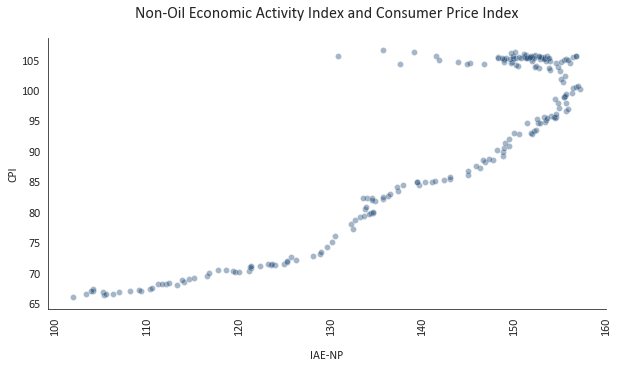

In [571]:
scatter_plot(df, 'iae_np', 'ipc', my_palette[0], 
            'Non-Oil Economic Activity Index and Consumer Price Index', 
            'IAE-NP', 
            'CPI')

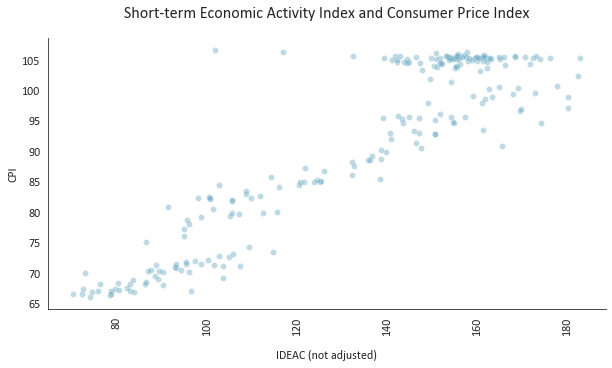

In [572]:
scatter_plot(df, 'ideac_sb', 'ipc', my_palette[1], 
            'Short-term Economic Activity Index and Consumer Price Index', 
            'IDEAC (not adjusted)', 
            'CPI')

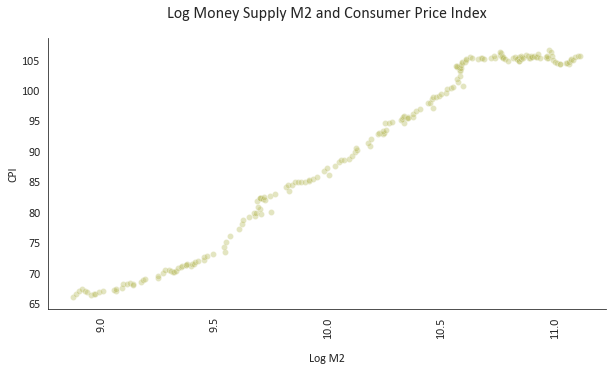

In [573]:
scatter_plot(df, np.log(df['liq_m2']), 'ipc', my_palette[2], 
            'Log Money Supply M2 and Consumer Price Index', 
            'Log M2', 
            'CPI')

##### **Time Series treatment**

**Unit Root Test**

* When dealing with time series data, prior to the estimation of the models, we tested for the existence of unit root. The presence of unit root can generate problems of spurious correlation, which means that the estimation determines coefficients that express a false relationship between variables.

* We need to make our time-series stationary: stationary means that the statistical properties like mean, variance, and autocorrelation of your dataset stay the same over time. If the series is not stationary, a difference is applied.

* We use the Augmented Dickey-Fuller Test.

In [574]:
# Unit Root Test: Augmented Dickey-Fuller unit root test
# H0: there is a unit root

from statsmodels.tsa.stattools import adfuller;

In [575]:
# Dataframe that will contain the stationary series
df_stat = df[['date']].copy()

# Function to create stationary variables
def gen_stationary(var):
  if adfuller(df[var], autolag = 'AIC')[1] > 0.05: # If H0 is not rejected at the 95% confidence level
    df_stat[var + '_diff'] = df[var].diff()
  else:
    df_stat[var] = df[var]

In [576]:
# Evaluate each variable in the dataframe
for var in df.drop(['date', 'pib_nom_USDK', 'pib_real_USDK'], axis = 1).columns:
  gen_stationary(var);

In [577]:
# Remove missing values in Ecuador CPI variable
df_stat = df_stat[df_stat['ipc_diff'].notna()]

df_stat.head()

,date,ipc_diff,ind_man_diff,ind_com_diff,ind_con_diff,ind_ser,iae_np_diff,ideac_ct_diff,ideac_sb_diff,base_mon_diff,...,CPI_US_diff,TNX_diff,pos_divisas,oro_monetario_diff,DEGs_diff,pos_reserva_FMI_diff,pos_ALADI_diff,res_internacional,ipp_diff,ipcons_diff
1,2004-02-01,0.45,3.546210,0.668855,0.678140,107.276700,1.434140,0.650352,-3.774256,25.919999,...,0.4,-0.066289,844.86,-3.29,-7.50,-0.02,0.42,1206.57,2.03,3.32
2,2004-03-01,0.47,1.427681,1.614885,0.367364,106.919136,0.741118,0.494428,12.551825,-114.177000,...,0.4,-0.257689,752.60,23.52,44.42,0.00,-0.63,1181.62,1.67,4.28
3,2004-04-01,0.43,0.575815,-0.368881,-0.283192,107.215493,0.034479,0.327072,-3.189030,13.916000,...,0.3,0.521097,867.16,-29.72,-30.06,-0.49,0.15,1236.06,-0.35,3.69
4,2004-05-01,-0.32,-1.868806,-0.045951,0.558103,107.619727,-0.194820,0.191546,-3.710760,91.460046,...,0.8,0.367881,866.90,4.00,-7.06,0.29,-0.05,1232.98,-0.65,4.55
5,2004-06-01,-0.20,1.701484,1.395899,1.635849,107.791548,1.260982,0.094894,-1.325310,45.623234,...,0.7,0.018310,849.38,2.16,-0.01,-0.02,-0.77,1216.81,-0.41,1.43


In [578]:
# Correlation matrix
num_cols = df_stat.drop(['date'], axis = 1).columns
df_stat[num_cols].corr().head()

,ipc_diff,ind_man_diff,ind_com_diff,ind_con_diff,ind_ser,iae_np_diff,ideac_ct_diff,ideac_sb_diff,base_mon_diff,caja_bce_diff,...,CPI_US_diff,TNX_diff,pos_divisas,oro_monetario_diff,DEGs_diff,pos_reserva_FMI_diff,pos_ALADI_diff,res_internacional,ipp_diff,ipcons_diff
ipc_diff,1.000000,0.009423,0.009845,0.000277,0.004398,0.010990,0.052844,-0.221017,-0.075886,0.048022,...,-0.006946,-0.033203,0.133017,0.113654,0.021946,0.039248,0.029572,0.113376,0.103436,0.315791
ind_man_diff,0.009423,1.000000,0.874425,0.784192,-0.032491,0.935315,0.265284,-0.006453,-0.089855,0.078593,...,0.102056,0.182046,0.026904,0.219601,0.008481,0.009337,-0.031756,0.058812,0.006698,0.100767
ind_com_diff,0.009845,0.874425,1.000000,0.848844,-0.003429,0.957355,0.160043,-0.061633,-0.152048,0.122957,...,0.025434,0.108565,0.004537,0.149926,-0.009712,-0.052434,-0.039135,0.022926,-0.046281,0.072240
ind_con_diff,0.000277,0.784192,0.848844,1.000000,0.034856,0.923613,0.142563,-0.074045,-0.177942,0.139201,...,0.071947,0.166135,0.046100,0.138719,0.010519,0.017680,-0.031608,0.075544,0.016668,0.126709
ind_ser,0.004398,-0.032491,-0.003429,0.034856,1.000000,-0.011932,-0.012997,-0.003171,0.062536,0.001425,...,-0.024030,-0.021134,0.475878,-0.038706,-0.002673,0.015870,-0.016128,0.634597,-0.052128,-0.188858


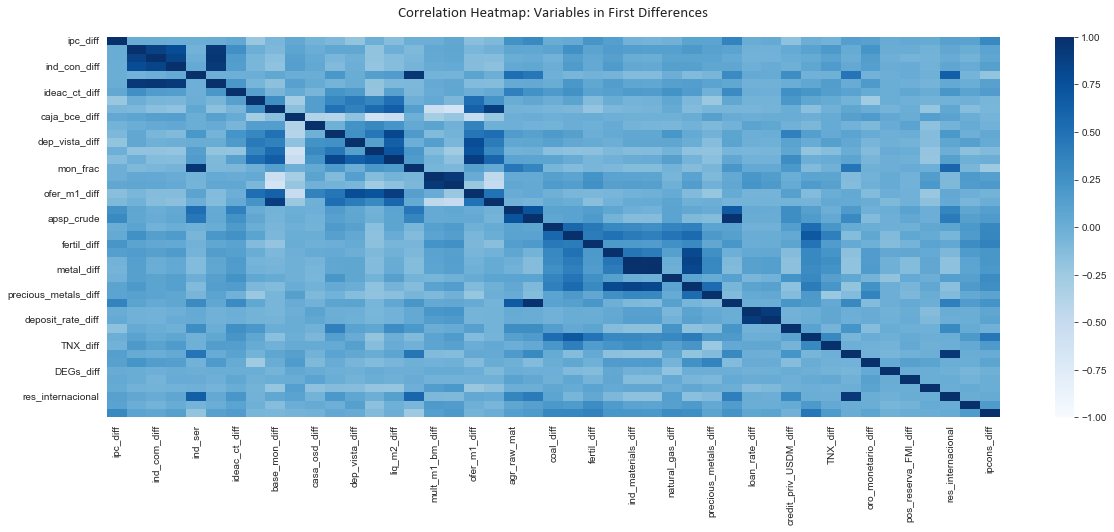

In [579]:
# Heatmap: Correlation matrix in first differences
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.heatmap(df_stat[num_cols].corr(),
            vmin = -1, vmax = 1,
            cmap = 'Blues')
plt.title('Correlation Heatmap: Variables in First Differences', fontsize = 15, pad = 20, **csfont)
plt.gcf().set_size_inches(20, 7);

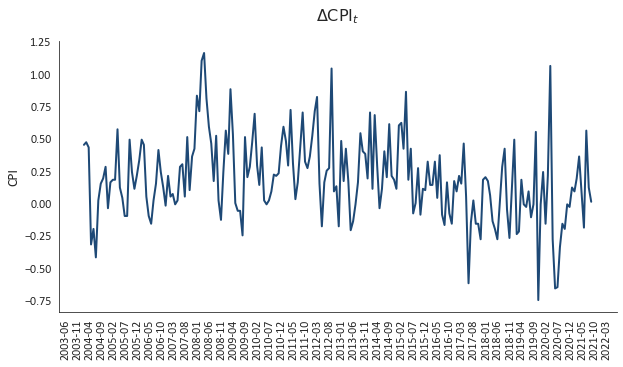

In [580]:
# Graph: CPI
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df_stat, x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], ax = ax)

plt.title('$\Delta\mathrm{CPI}_{t}$', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

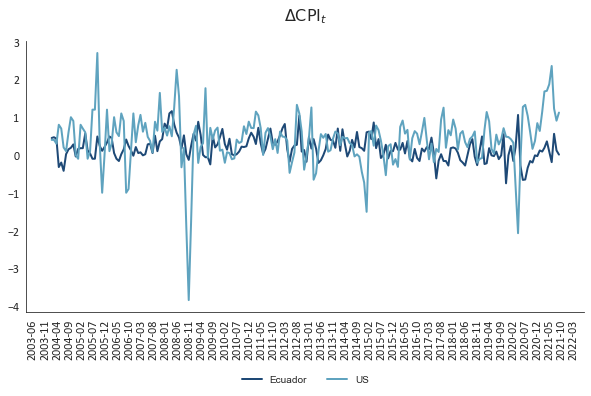

In [581]:
# Graph: CPI (Ecuador vs US)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df_stat, x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], label = 'Ecuador', ax = ax)
sns.lineplot(data = df_stat, x = 'date', y = 'CPI_US_diff', linewidth = 2, color = my_palette[1], label = 'US', ax = ax)

plt.title('$\Delta\mathrm{CPI}_{t}$', fontsize = 16, pad = 20, **csfont)
plt.ylabel('', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

##### **Training and Testing Datasets**

* Split the dataset to create a training and a testing dataset (proportion of 75 to 25).

Stationary and level datasets

In [582]:
print(df_stat.shape[0] * 0.75) # 75% of the data

159.0


In [583]:
df_stat.sort_values(['date'], inplace = True)
df_stat.loc[159, 'date']

Timestamp('2017-04-01 00:00:00')

In [584]:
# Testing and Training Datasets
f1 = df_stat['date'] <= '2019-10-01' 
f2 = df_stat['date'] > '2019-10-01'

df_stat_train = df_stat.loc[f1, :]
df_stat_test = df_stat.loc[f2, :]

In [585]:
# Testing and Training Datasets
f1 = df['date'] <= '2019-10-01' 
f2 = df['date'] > '2019-10-01'

df_train = df.loc[f1, :]
df_test = df.loc[f2, :]

##### **ARIMA Forecasting Model**

First, an exercise is carried out to estimate the behavior of inflation, through the CPI, using an ARIMA model, which consists of a univariate time series model.

To estimate the orders of an ARIMA model $\left( p,d,q \right)$, we use the Hyndman-Khandakar algorithm ([Link](https://www.jstatsoft.org/article/view/v027i03)), which combines unit root tests, minimisation of the AICc and MLE to obtain an ARIMA model.

* ACF and PACF graphs to determine the orders of q and p.

In [586]:
import statsmodels.api as sm

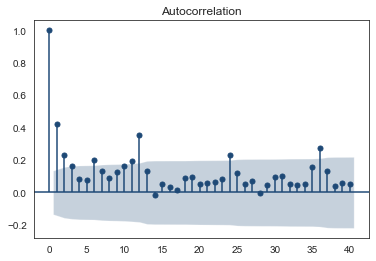

In [587]:
# Autocorrelation function
sm.graphics.tsa.plot_acf(df_stat['ipc_diff'], lags = 40);

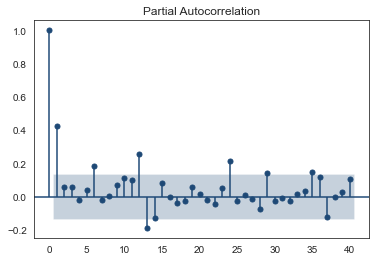

In [588]:
# Partial autocorrelation function
sm.graphics.tsa.plot_pacf(df_stat['ipc_diff'], lags = 40);

In [589]:
# Reference: https://brittarude.github.io/blog/2020/11/22/britta-rude-forecasting-with-python
# pip install pmdarima

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

cpi_arima1 = pm.auto_arima(df['ipc'],
                           seasonal = False, d = 1)

cpi_arima2 = pm.auto_arima(df['ipc'],
                           seasonal = False, d = 1,
                           approximation = False, stepwise = False)

cpi_arima3 = pm.auto_arima(df['ipc'],
                           seasonal = True, d = 1)

cpi_arima4 = pm.auto_arima(df['ipc'],
                           seasonal = True, d = 1,
                           approximation = False, stepwise = False)

In [590]:
# Vector with the AICs of the models
arima_aic = []
arima_aic.append(cpi_arima1.aic())
arima_aic.append(cpi_arima2.aic())
arima_aic.append(cpi_arima3.aic())
arima_aic.append(cpi_arima4.aic())

print('AIC')
arima_aic

AIC


[71.54542595503997, 71.61977948118744, 71.54542595503997, 71.61977948118744]

In [591]:
# Model with the lowest AIC
print(np.argmin(arima_aic) + 1)

1


In [592]:
# Summary
cpi_arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 -31.773
Date:                Sun, 20 Mar 2022   AIC                             71.545
Time:                        20:29:24   BIC                             84.972
Sample:                             0   HQIC                            76.972
                                - 213                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3261      0.059     22.488      0.000       1.210       1.442
ar.L2         -0.3298      0.058     -5.695      0.000      -0.443      -0.216
ma.L1         -0.9494      0.031    -30.707      0.000      -1.010      -0.889
sigma2         0.0786      0.006     12.154      0.000       0.066       0.091
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.36
Prob(Q):                              0.98   Prob(JB):                         0.04
Heteroskedasticity (H):               1.30   Skew:                             0.09
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Check the robustness of our model

In [593]:
# Ljung-Box test of autocorrelation in residuals
sm.stats.acorr_ljungbox(cpi_arima1.resid(), lags = 10, return_df = True)

,lb_stat,lb_pvalue
1,0.009582,0.922020
2,0.011825,0.994105
3,0.012820,0.999615
4,0.033227,0.999864
5,0.035447,0.999988
6,0.043518,0.999998
7,0.044217,1.000000
8,0.044530,1.000000
9,0.044842,1.000000
10,0.046084,1.000000


Residuals are stationary

C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


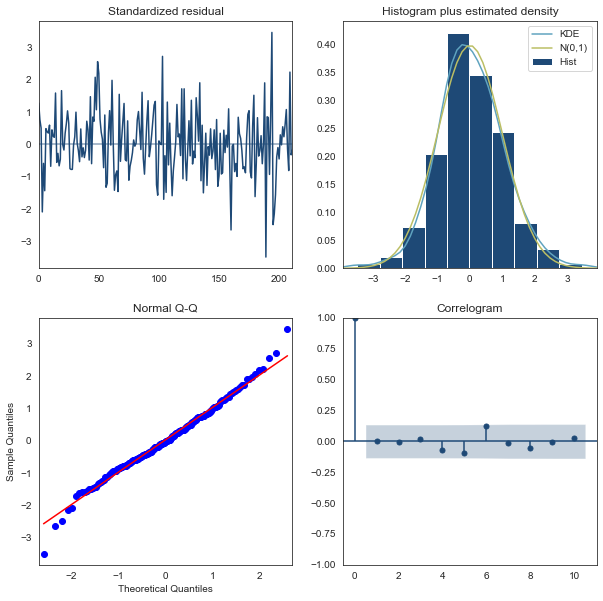

In [594]:
cpi_arima1.plot_diagnostics(figsize = (10, 10))
plt.show();

In [595]:
# Model estimation between training and testing datasets
# Reference: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html#statsmodels.tsa.arima.model.ARIMAResults.get_forecast

cpi_arima = sm.tsa.arima.ARIMA(df_train['ipc'].values, order = (2, 1, 1))
cpi_arima_fit = cpi_arima.fit()
cpi_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  190
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -14.334
Date:                Sun, 20 Mar 2022   AIC                             36.668
Time:                        20:29:25   BIC                             49.635
Sample:                             0   HQIC                            41.921
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3817      0.076     18.160      0.000       1.233       1.531
ar.L2         -0.3853      0.074     -5.184      0.000      -0.531      -0.240
ma.L1         -0.9485      0.035    -27.083      0.000      -1.017      -0.880
sigma2         0.0677      0.007      9.625      0.000       0.054       0.081
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.90   Prob(JB):                         0.57
Heteroskedasticity (H):               0.95   Skew:                             0.19
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [596]:
# Forecast
# https://stackoverflow.com/questions/66651360/arima-forecast-gives-different-results-with-new-python-statsmodels?rq=1
# https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html

n_steps = len(df_test['ipc'])
cpi_forecast = cpi_arima_fit.get_forecast(steps = n_steps, dynamic = True)
cpi_forecast_ci = cpi_forecast.summary_frame(alpha = 0.05)

In [597]:
# # In-sample one-step-ahead predictions
# predict = cpi_arima_fit.get_prediction()
# predict_ci = predict.conf_int()

# # Dynamic predictions
# predict_dy = cpi_arima_fit.get_prediction(start = start_p, end = end_p, dynamic = True)
# predict_dy_ci = predict_dy.conf_int()

In [598]:
cpi_forecast_ci['date'] = pd.date_range(df_test['date'].min(), freq = 'M', periods = len(cpi_forecast_ci))
cpi_forecast_ci['date'] = cpi_forecast_ci['date'] - pd.offsets.MonthBegin(1)

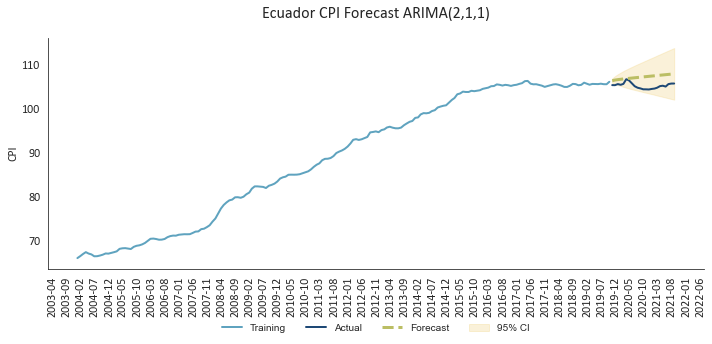

In [599]:
# Plot the CPI forecast from the ARIMA model
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = df_train, x = 'date', y = 'ipc', linewidth = 2, color = my_palette[1], label = 'Training', ax = ax)
sns.lineplot(data = df_test, x = 'date', y = 'ipc', linewidth = 2, color = my_palette[0], label = 'Actual', ax = ax)
sns.lineplot(data = cpi_forecast_ci, x = 'date', y = 'mean', linewidth = 3, color = my_palette[2], label = 'Forecast', linestyle = '--', ax = ax)

plt.fill_between(cpi_forecast_ci['date'], cpi_forecast_ci['mean_ci_lower'], cpi_forecast_ci['mean_ci_upper'], color = my_palette[3], alpha = 0.25, label = '95% CI')

plt.title('Ecuador CPI Forecast ARIMA(2,1,1)', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 4,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_ARIMA_forecast.png', dpi = 500)

In [600]:
metrics_arima = metrics.mean_squared_error(df_test['ipc'], cpi_forecast_ci['mean'])
metrics_arima

4.644702693577294

In [601]:
metrics_arima_1d = metrics.mean_squared_error(df_test['ipc'].diff()[1:], cpi_forecast_ci['mean'].diff()[1:])
metrics_arima_1d

0.13597160540224879

In [602]:
# Prediction
start_p = len(df_train)
end_p = start_p + len(df_test)

cpi_predict = cpi_arima_fit.get_prediction(start = start_p, end = end_p, dynamic = True)
cpi_predict_ci = cpi_predict.summary_frame(alpha = 0.05)

In [603]:
cpi_predict_ci['date'] = pd.date_range(df_test['date'].min(), freq = 'M', periods = len(cpi_predict_ci))
cpi_predict_ci['date'] = cpi_predict_ci['date'] - pd.offsets.MonthBegin(1)

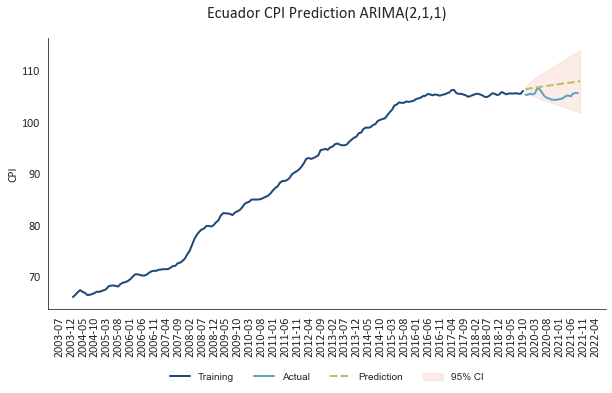

In [604]:
# Plot the CPI prediction from the ARIMA model
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = df_train, x = 'date', y = 'ipc', linewidth = 2, color = my_palette[0], label = 'Training', ax = ax)
sns.lineplot(data = df_test, x = 'date', y = 'ipc', linewidth = 2, color = my_palette[1], label = 'Actual', ax = ax)
sns.lineplot(data = cpi_predict_ci, x = 'date', y = 'mean', linewidth = 2, color = my_palette[2], label = 'Prediction', linestyle = '--', ax = ax)

plt.fill_between(cpi_predict_ci['date'], cpi_predict_ci['mean_ci_lower'], cpi_predict_ci['mean_ci_upper'], color = my_palette[4], alpha = 0.15, label = '95% CI')

plt.title('Ecuador CPI Prediction ARIMA(2,1,1)', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 4,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

##### **VAR Model**

A VAR model, previously used in an institution, is estimated in order to forecast inflation. This estimation, in the institution where it is used, is called the "Monetary Approach". For this purpose, the following model is estimated:

**VAR(p) "Monetary Approach":**

$$
\begin{bmatrix}
\Delta CPI_{t} \\ 
\Delta PriLoan_{t} \\ 
\Delta DepotRate_{t} \\ 
\Delta M2_{t}
\end{bmatrix} 
= 
\alpha 
+ 
B_{1} 
\begin{bmatrix} 
\Delta CPI_{t-1} \\ 
\Delta PriLoan_{t-1} \\ 
\Delta DepotRate_{t-1} \\
\Delta M2_{t-1}
\end{bmatrix} 
+ 
\cdots 
+ 
B_{p}
\begin{bmatrix}
\Delta CPI_{t-p}\\ 
\Delta PriLoan_{t-p} \\ 
\Delta DepotRate_{t-p} \\ 
\Delta M2_{t-p}
\end{bmatrix} 
+ 
\varepsilon_{t}
$$

In [605]:
# Variables
df_stat['credit_priv_USDM_pc'] = df['credit_priv_USDM'].pct_change(periods = 1)

In [606]:
# Testing and Training Datasets
f1 = df_stat['date'] <= '2020-09-01' 
f2 = df_stat['date'] > '2020-09-01'

df_stat_train = df_stat.loc[f1, :]
df_stat_test = df_stat.loc[f2, :]

In [607]:
# VAR
from statsmodels.tsa.api import VAR
from sklearn import metrics

start_date = '2020-10-01'
end_date = '2021-09-01'

df_stat1 = df_stat.copy()
df_stat1 = df_stat1.set_index('date')

In [608]:
# Reference: https://notes.quantecon.org/submission/5cc8e7dd4174bb001a39a8ff

# Function to estimate the model
def var_estimation(columns, df_stat1, lags, mforecast):

  data = df_stat1[columns]
  data = data.dropna(axis = 0)
  data.index.to_period('M')

  # Split dataset
  data_train  = data.loc[:'2020-09', :]

  # Model estimation
  var_train = VAR(data_train)
  results = var_train.fit(maxlags = lags)
  lag_order = results.k_ar
  forecasted = pd.DataFrame(results.forecast(data_train.values[-lag_order:], mforecast)) # mforecast: Number of months to forecast
  
  # Rename forecasted columns
  forecasted_names = list(forecasted.columns.values)
  data_train_names = list(data_train.columns.values)

  var_dict = dict(zip(forecasted_names, data_train_names))

  for f,t in var_dict.items():
    forecasted = forecasted.rename(columns={f:t + '_fcast'})

  # forecasted.index = pd.DatetimeIndex(start = start_date, periods = forecasted.shape[0], freq = 'MS')
  forecasted.index = pd.date_range(start_date, freq = 'MS', periods = forecasted.shape[0])
  forecasted.index.names = ['date']

  # Parse together forecasted data with original dataset
  final_data = pd.merge(forecasted, data, left_index = True, right_index = True)
  final_data = final_data.sort_index(axis = 0, ascending = True)
  final_data = pd.concat([data_train, final_data], sort = True, axis = 0)
  final_data = final_data.sort_index(axis = 0, ascending = True)
   
  var_mse = metrics.mean_squared_error(final_data.loc[start_date:end_date, 'ipc_diff_fcast'], 
                           final_data.loc[start_date:end_date, 'ipc_diff'])
    
  return var_mse, final_data

In [609]:
var_endog = ['ipc_diff', 'credit_priv_USDM_pc', 'deposit_rate_diff', 'liq_m2_diff'] 

mse1, df1 = var_estimation(var_endog, df_stat1, 3, 12)

print(f"The mean squared error between the forecasted and actual values is {mse1}")

The mean squared error between the forecasted and actual values is 0.034364642298143705


C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [610]:
# Reference: https://notes.quantecon.org/submission/5cc8e7dd4174bb001a39a8ff

# Function to graph result
def plot_var(final_data, var_mse, approach):
  
  fig, ax = plt.subplots(nrows = 1, ncols = 1)

  sns.lineplot(data = final_data[final_data['date'] <= '2020-09-01'], x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], label = 'Training', ax = ax)
  sns.lineplot(data = final_data[final_data['date'] > '2020-09-01'], x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[1], label = 'Actual', ax = ax)
  sns.lineplot(data = final_data, x = 'date', y = 'ipc_diff_fcast', linewidth = 2, color = my_palette[5], label = 'Forecast', ax = ax)

  plt.title(f'VAR in-sample forecast. {approach} approach', fontsize = 16, pad = 20, **csfont)
  plt.ylabel('$\Delta$CPI', fontsize = 12, **csfont)
  plt.yticks(fontsize = 12, **csfont)
  plt.xlabel('')
  plt.xticks(fontsize = 12, rotation = 90, **csfont)

  plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

  date_form = DateFormatter("%Y-%m")
  ax.xaxis.set_major_formatter(date_form)
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

  sns.despine()
  plt.gcf().set_size_inches(10, 5);

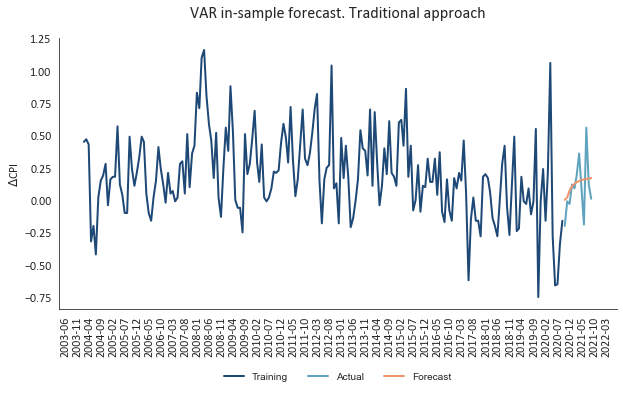

In [611]:
# Graph - Traditional approach
plot_var(df1.reset_index(), mse1, 'Traditional')

* **VAR: Traditional approach**

In [612]:
# Variables to use in the VAR(p) model
data = df_stat[['ipc_diff', 'credit_priv_USDM_pc', 'deposit_rate_diff', 'liq_m2_diff']]
data.index = df_stat['date']

In [613]:
# Testing and Training Datasets
train = data.loc[:'2019-09-01', :]
test = data.loc['2019-10-01':, :]

In [614]:
# Select the order of the VAR model according to the AIC criterion. Select p
var_model = VAR(train)
results_aic = []
for p in range(1,12):
  results = var_model.fit(p)
  results_aic.append(results.aic)

C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


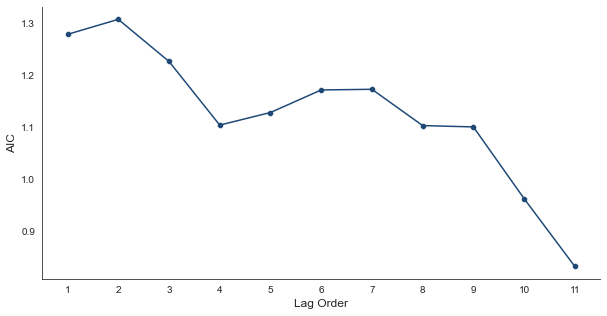

In [615]:
# Optimal lag order 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))

sns.scatterplot(x = list(np.arange(1, 12, 1)), y = results_aic)
axes.plot(list(np.arange(1, 12, 1)), results_aic)
axes.set_xlabel('Lag Order', fontsize = 12)
axes.set_ylabel('AIC', fontsize = 12)

axes.set_xticks(range(1,12))

sns.despine();

* Based on these results, we select 4 lags as the optimal order of the VAR model 

In [616]:
# VAR(4) estimation
results = var_model.fit(4)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Mar, 2022
Time:                     20:29:32
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    2.29290
Nobs:                     184.000    HQIC:                   1.58634
Log likelihood:          -1077.98    FPE:                    3.02493
AIC:                      1.10477    Det(Omega_mle):         2.12423
--------------------------------------------------------------------
Results for equation ipc_diff
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.027827         0.041374            0.673           0.501
L1.ipc_diff                    0.476180         0.072990            6.524           0.000
L1.credit_priv_USDM_p

In [617]:
lagged_values = train.values[-4:] # Because of 4 lag order

# Point estimates
forecast_point = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[0],
                              index = test.index, columns = ['ipc_diff_f', 'credit_priv_USDM_pc_f', 'deposit_rate_diff_f', 'liq_m2_diff_f'])

# Lower 
forecast_lower = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[1],
                              index = test.index, columns = ['ipc_diff_lf', 'credit_priv_USDM_pc_lf', 'deposit_rate_diff_lf', 'liq_m2_diff_lf'])

# Upper
forecast_upper = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[2],
                              index = test.index, columns = ['ipc_diff_uf', 'credit_priv_USDM_pc_uf', 'deposit_rate_diff_uf', 'liq_m2_diff_uf'])

In [618]:
# CPI forecast
forecast = pd.concat([forecast_point['ipc_diff_f'], forecast_lower['ipc_diff_lf'], forecast_upper['ipc_diff_uf']], axis = 1)
forecast.reset_index(inplace = True)

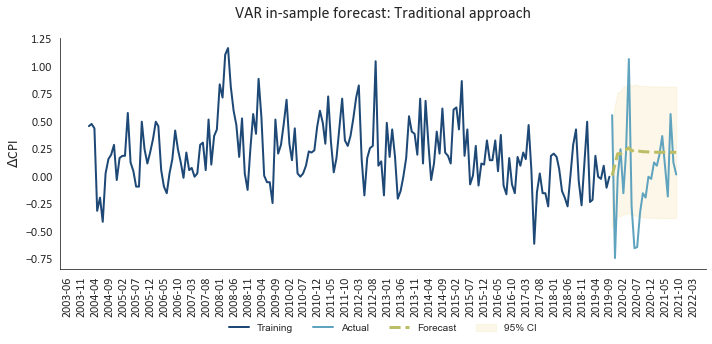

In [619]:
# Graph: CPI (Ecuador vs US)
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = train.reset_index(), x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], label = 'Training', ax = ax)
sns.lineplot(data = test.reset_index(), x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[1], label = 'Actual', ax = ax)
sns.lineplot(data = forecast.reset_index(), x = 'date', y = 'ipc_diff_f', linewidth = 3, color = my_palette[2], linestyle = '--', label = 'Forecast', ax = ax)

plt.fill_between(forecast['date'], forecast['ipc_diff_lf'], forecast['ipc_diff_uf'], color = my_palette[3], alpha = 0.15, label = '95% CI')

plt.title('VAR in-sample forecast: Traditional approach', fontsize = 16, pad = 20, **csfont)
plt.ylabel('$\Delta$CPI', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 4,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))


sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_VAR_Traditional_forecast.png', dpi = 500)

In [620]:
metrics_traditional = metrics.mean_squared_error(test['ipc_diff'], forecast['ipc_diff_f'])
metrics_traditional

0.20133000705208057

* **VAR: Lasso approach**

In [621]:
# Explanatory and dependent variable
X = df_stat.drop(['date', 'ipc_diff'], axis = 1)
X.index = df_stat['date']

y = df_stat[['ipc_diff']]
y.index = df_stat['date']

In [622]:
# Training and testing datasets
X_train = X.loc[:'2019-09-01', :]
y_train = y.loc[:'2019-09-01', :]

X_test = X.loc['2019-10-01':, :]
y_test = y.loc['2019-10-01':, :]

In [623]:
# Linear model
lasso_1 = linear_model.LassoCV(cv = model_selection.TimeSeriesSplit(n_splits = 5),
                              alphas = None, tol = 10000, normalize = True)

lasso_est_1 = lasso_1.fit(X, y)
optimal_alpha = lasso_est_1.alpha_

lasso_2 = linear_model.Lasso(optimal_alpha, normalize = True)
lasso_2.fit(X_train, y_train)

C:\Users\fvill\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Lasso(alpha=0.004461161502667898, normalize=True)

C:\Users\fvill\AppData\Local\Temp/ipykernel_10744/286053723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['ipc_diff_flasso'] = lasso_2.predict(X_test)


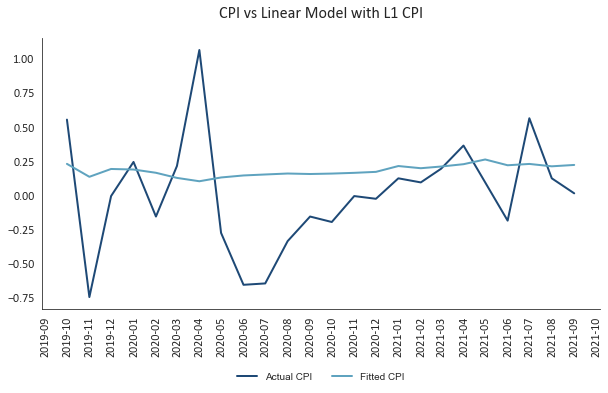

In [624]:
# Plot
y_test['ipc_diff_flasso'] = lasso_2.predict(X_test)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = y_test, x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], label = 'Actual CPI', ax = ax)
sns.lineplot(data = y_test, x = 'date', y = 'ipc_diff_flasso', linewidth = 2, color = my_palette[1], label = 'Fitted CPI', ax = ax)

plt.title("CPI vs Linear Model with L1 CPI", fontsize = 16, pad = 20, **csfont)
plt.ylabel('', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

sns.despine()
plt.gcf().set_size_inches(10, 5);

In [625]:
metrics.mean_squared_error(y_test['ipc_diff'], y_test['ipc_diff_flasso'])

0.1804928286335741

In [626]:
# Feature selection
lasso_coefs = pd.DataFrame({'features': list(X_train), 'coef': lasso_2.coef_})
lasso_coefs = lasso_coefs[lasso_coefs != 0.0]
lasso_coefs.sort_values('coef', ascending = False, inplace = True)
lasso_coefs[lasso_coefs['coef'].notna()]

,features,coef
43,ipcons_diff,0.008672
30,wti_price,0.001900
24,food_bever_diff,0.001054


In [627]:
# Variables to use in the VAR(p) model
data = df_stat[['ipc_diff', 'ipcons_diff', 'wti_price', 'food_bever_diff']]
data.index = df_stat['date']

# Testing and Training Datasets
train = data.loc[:'2019-09-01', :]
test = data.loc['2019-10-01':, :]

In [628]:
# Select the order of the VAR model according to the AIC criterion. Select p
var_model = VAR(train)
results_aic = []
for p in range(1,12):
  results = var_model.fit(p)
  results_aic.append(results.aic)

C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


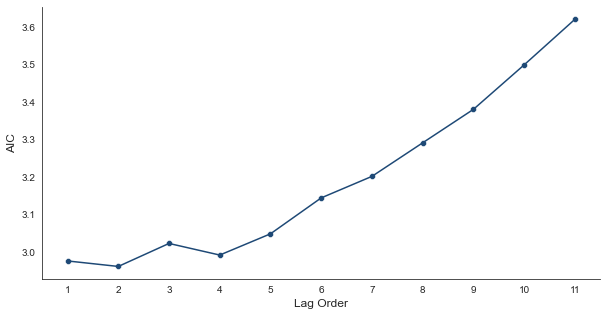

In [629]:
# Optimal lag order 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))

sns.scatterplot(x = list(np.arange(1, 12, 1)), y = results_aic)
axes.plot(list(np.arange(1, 12, 1)), results_aic)
axes.set_xlabel('Lag Order', fontsize = 12)
axes.set_ylabel('AIC', fontsize = 12)

axes.set_xticks(range(1,12))

sns.despine();

In [630]:
# VAR(4) estimation
results = var_model.fit(2)
results.summary()
lagged_values = train.values[-2:] # Because of 4 lag order

In [631]:
# Point estimates
forecast_point = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[0],
                              index = test.index, columns = ['ipc_diff_f', 'ipcons_diff_f', 'wti_price_f', 'food_bever_diff_f'])

# Lower 
forecast_lower = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[1],
                              index = test.index, columns = ['ipc_diff_lf', 'ipcons_diff_lf', 'wti_price_lf', 'food_bever_diff_lf'])

# Upper
forecast_upper = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[2],
                              index = test.index, columns = ['ipc_diff_uf', 'ipcons_diff_uf', 'wti_price_uf', 'food_bever_diff_uf'])

In [632]:
# CPI forecast
forecast = pd.concat([forecast_point['ipc_diff_f'], forecast_lower['ipc_diff_lf'], forecast_upper['ipc_diff_uf']], axis = 1)
forecast.reset_index(inplace = True)

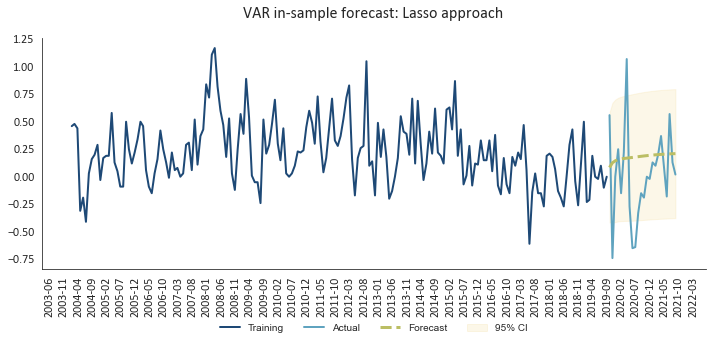

In [633]:
# Graph
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = train.reset_index(), x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], label = 'Training', ax = ax)
sns.lineplot(data = test.reset_index(), x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[1], label = 'Actual', ax = ax)
sns.lineplot(data = forecast.reset_index(), x = 'date', y = 'ipc_diff_f', linewidth = 3, color = my_palette[2], linestyle = '--', label = 'Forecast', ax = ax)

plt.fill_between(forecast['date'], forecast['ipc_diff_lf'], forecast['ipc_diff_uf'], color = my_palette[3], alpha = 0.15, label = '95% CI')

plt.title('VAR in-sample forecast: Lasso approach', fontsize = 16, pad = 20, **csfont)
plt.ylabel('', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 4,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))


sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_VAR_Lasso_forecast.png', dpi = 500)

In [634]:
metrics_lasso = metrics.mean_squared_error(test['ipc_diff'], forecast['ipc_diff_f'])
metrics_lasso

0.18515203639442127

* **VAR: XGBoost approach**

In [635]:
# Normalize features
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [636]:
# XGBoost estimation
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

C:\Users\fvill\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\fvill\AppData\Local\Temp/ipykernel_10744/1271086579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['ipc_diff_fxgb'] = xgb_model.predict(X_test)


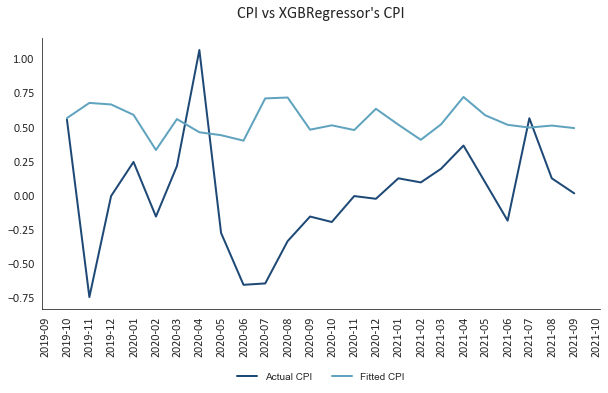

In [637]:
# Plot
y_test['ipc_diff_fxgb'] = xgb_model.predict(X_test)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = y_test, x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], label = 'Actual CPI', ax = ax)
sns.lineplot(data = y_test, x = 'date', y = 'ipc_diff_fxgb', linewidth = 2, color = my_palette[1], label = 'Fitted CPI', ax = ax)

plt.title("CPI vs XGBRegressor's CPI", fontsize = 16, pad = 20, **csfont)
plt.ylabel('', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

sns.despine()
plt.gcf().set_size_inches(10, 5);

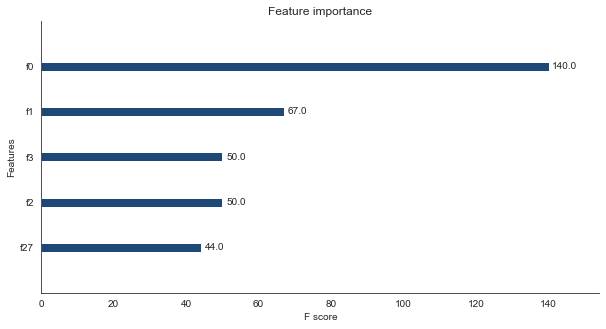

In [638]:
# Feature importance
fig, ax = plt.subplots(figsize = (10, 5))
plot_importance(xgb_model, max_num_features = 5, ax = ax)
sns.despine()
ax.grid(False)

In [639]:
# Feature selection
feat_importance = [0, 1, 3, 2, 27]

for i, name in dict(zip(list(range(len(X_train.columns))), list(X_train.columns.values))).items():
  if i in feat_importance:
    print(f'Feature {i} is {name}')   

Feature 0 is ind_man_diff
Feature 1 is ind_com_diff
Feature 2 is ind_con_diff
Feature 3 is ind_ser
Feature 27 is natural_gas_diff


In [640]:
# Variables to use in the VAR(p) model
data = df_stat[['ipc_diff', 'ind_man_diff', 'ind_com_diff', 'ind_con_diff', 'ind_ser', 'natural_gas_diff']]
data.index = df_stat['date']

# Testing and Training Datasets
train = data.loc[:'2019-09-01', :]
test = data.loc['2019-10-01':, :]

In [641]:
# Select the order of the VAR model according to the AIC criterion. Select p
var_model = VAR(train)
results_aic = []
for p in range(1,12):
  results = var_model.fit(p)
  results_aic.append(results.aic)

C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


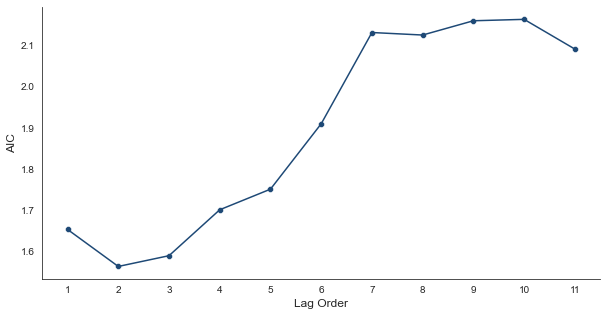

In [642]:
# Optimal lag order 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))

sns.scatterplot(x = list(np.arange(1, 12, 1)), y = results_aic)
axes.plot(list(np.arange(1, 12, 1)), results_aic)
axes.set_xlabel('Lag Order', fontsize = 12)
axes.set_ylabel('AIC', fontsize = 12)

axes.set_xticks(range(1,12))

sns.despine();

In [643]:
# VAR(4) estimation
results = var_model.fit(2)
results.summary()
lagged_values = train.values[-2:] # Because of 4 lag order

In [644]:
# Point estimates
forecast_point = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[0],
                              index = test.index, columns = ['ipc_diff_f', 'ind_man_diff_f', 'ind_com_diff_f', 'ind_con_diff_f', 'ind_ser_f', 'natural_gas_diff_f'])

# Lower 
forecast_lower = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[1],
                              index = test.index, columns = ['ipc_diff_lf', 'ind_man_diff_lf', 'ind_com_diff_lf', 'ind_con_diff_lf', 'ind_ser_lf', 'natural_gas_diff_lf'])

# Upper
forecast_upper = pd.DataFrame(results.forecast_interval(y = lagged_values, steps = 24, alpha = 0.05)[2],
                              index = test.index, columns = ['ipc_diff_uf', 'ind_man_diff_uf', 'ind_com_diff_uf', 'ind_con_diff_uf', 'ind_ser_uf', 'natural_gas_diff_uf'])

In [645]:
# CPI forecast
forecast = pd.concat([forecast_point['ipc_diff_f'], forecast_lower['ipc_diff_lf'], forecast_upper['ipc_diff_uf']], axis = 1)
forecast.reset_index(inplace = True)

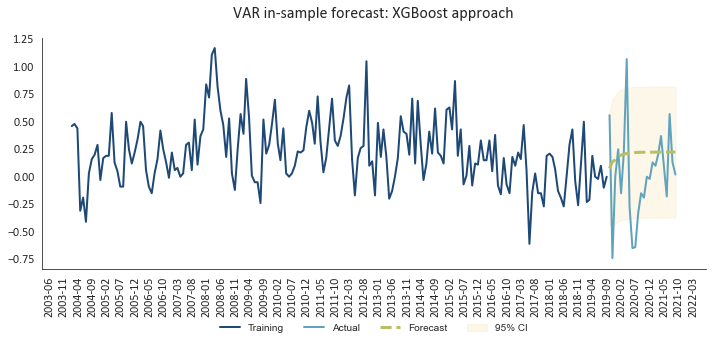

In [646]:
# Graph
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = train.reset_index(), x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[0], label = 'Training', ax = ax)
sns.lineplot(data = test.reset_index(), x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette[1], label = 'Actual', ax = ax)
sns.lineplot(data = forecast.reset_index(), x = 'date', y = 'ipc_diff_f', linewidth = 3, color = my_palette[2], linestyle = '--', label = 'Forecast', ax = ax)

plt.fill_between(forecast['date'], forecast['ipc_diff_lf'], forecast['ipc_diff_uf'], color = my_palette[3], alpha = 0.15, label = '95% CI')

plt.title('VAR in-sample forecast: XGBoost approach', fontsize = 16, pad = 20, **csfont)
plt.ylabel('', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 4,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))


sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_VAR_XGBoost_forecast.png', dpi = 500)

In [647]:
metrics_xgb = metrics.mean_squared_error(test['ipc_diff'], forecast['ipc_diff_f'])
metrics_xgb

0.19723020683849923

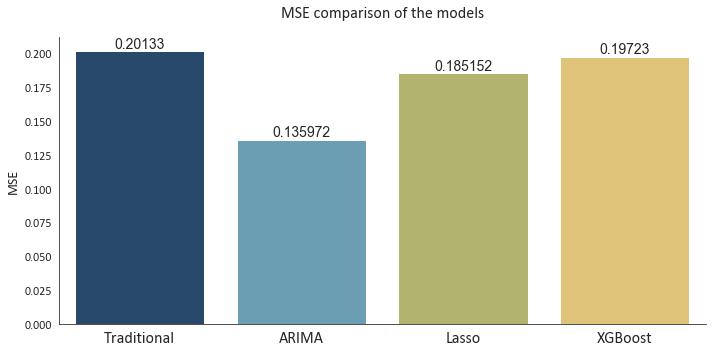

In [667]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.barplot(x = ['Traditional', 'ARIMA', 'Lasso', 'XGBoost'], y = [metrics_traditional, metrics_arima_1d, metrics_lasso, metrics_xgb])
plt.title('MSE comparison of the models', fontsize = 16, pad = 20, **csfont)
plt.ylabel('MSE', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 16, **csfont)

ax.bar_label(ax.containers[0], fontsize = 14)

sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_MSE_Comparison.png', dpi = 500)

* **Recurrent Neural Networks (RNN)**

In [649]:
# Libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [650]:
# Data
data = df.drop(['date'], axis = 1).copy()
data.index = df['date']

train = np.array(data.loc[:'2020-09-01', 'ipc'])
test = np.array(data.loc['2020-10-01':, 'ipc'])

In [651]:
# Scale features
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train.reshape(-1, 1))
test = scaler.transform(test.reshape(-1, 1))

In [652]:
# Reshape data

periods = 24 # use the previous x months to predict the next month's CPI

train_features = []
months = []
for i in range(periods, train.shape[0]):
  train_features.append(train[i - periods:i, 0])
  months.append(train[i, 0])

In [653]:
# Convert data to matrix and reshape 
train_features, months = np.array(train_features), np.array(months)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)

Step 1: Define the structure of our network

In [654]:
# Input
input_shape = train_features.shape[1:]
input_shape

(24, 1)

In [655]:
# Sequential Model
model_rnn = Sequential()

We are going to use 3 LSTM layers in this network.

Since we are doing a regression, we will use the linear activation function in the output layer.

In [656]:
# LSTM Layer
model_rnn.add(LSTM(units = 50,
                    return_sequences = True, # True if the next layer will be a recurring one
                    input_shape = input_shape))
model_rnn.add(LSTM(units = 50,
                    return_sequences = True))
model_rnn.add(LSTM(units = 50,
                    return_sequences = False))

# Capa de salida
model_rnn.add(Dense(units = 1, activation = 'linear'))

Step 2: Compile the model

Since this is a regression problem, we will use the root mean square error as the loss function.

In [657]:
# Compile the model
model_rnn.compile(loss = 'mean_squared_error', optimizer = 'adam')

Step 3: Fit the model

In [658]:
# Fit the model
history = model_rnn.fit(train_features, months, epochs = 100);

Epoch 1/100
6/6 [==============================] - 4s 22ms/step - loss: 0.3975
Epoch 2/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0607
Epoch 3/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0205
Epoch 4/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0283
Epoch 5/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0077
Epoch 6/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0092
Epoch 7/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0057
Epoch 8/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0030
Epoch 9/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0026
Epoch 10/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0014
Epoch 11/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0011
Epoch 12/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0012
Epoch 13/100
6/6 [==============================]

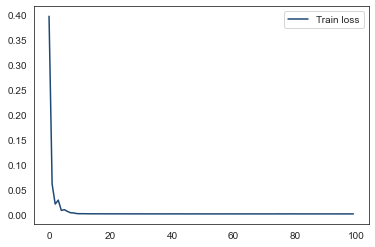

In [659]:
# Visualize the loss
plt.plot(history.history['loss'], label = 'Train loss')
plt.legend();

Forecast

In [660]:
test_months = pd.DataFrame(full)[len(full) - len(test) - periods:].values

# Get previous x months to use as functions
test_features = []
for i in range(periods, len(test_months)):
  test_features.append(test_months[i - periods:i, 0])

# Reformar
test_features = np.array(test_features)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [661]:
# Forecast
preds = model_rnn.predict(test_features)

In [662]:
# Datasets to plot
train_test_df = pd.DataFrame(np.concatenate((scaler.inverse_transform(train), scaler.inverse_transform(test))))
train_test_df.set_index(df['date'], inplace = True)
train_test_df.columns = ['ipc']
train_test_df.reset_index(inplace = True)

forecast_df = pd.DataFrame(scaler.inverse_transform(preds))
forecast_df.set_index(df[df['date'] >= '2020 - 10 - 01']['date'], inplace = True)
forecast_df.columns = ['ipc_f']
forecast_df.reset_index(inplace = True)

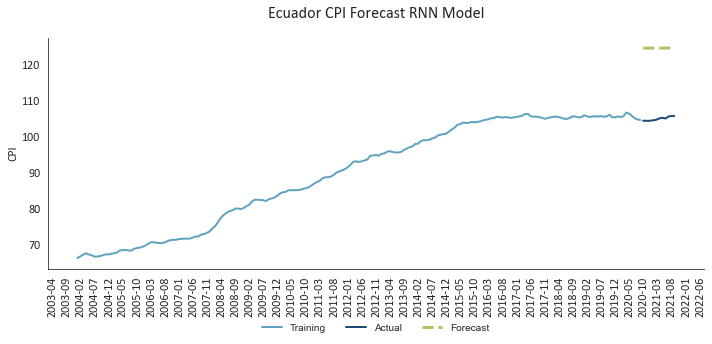

In [663]:
# Plot the CPI forecast from the RNN model
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = train_test_df[train_test_df['date'] <= '2020-09-01'], x = 'date', y = 'ipc', linewidth = 2, color = my_palette[1], label = 'Training', ax = ax)
sns.lineplot(data = train_test_df[train_test_df['date'] > '2020-09-01'], x = 'date', y = 'ipc', linewidth = 2, color = my_palette[0], label = 'Actual', ax = ax)
sns.lineplot(data = forecast_df, x = 'date', y = 'ipc_f', linewidth = 3, color = my_palette[2], label = 'Forecast', linestyle = '--', ax = ax)

plt.title('Ecuador CPI Forecast RNN Model', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

# Save graph
plt.tight_layout()
plt.savefig('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Results/graph_RNN_forecast.png', dpi = 500)

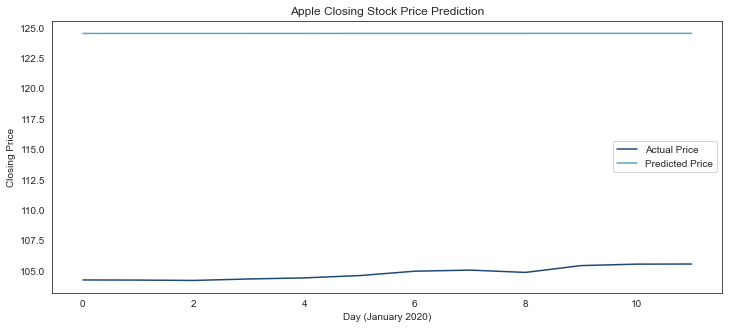

In [664]:
plt.figure(figsize = (12, 5))
plt.plot(scaler.inverse_transform(test), label='Actual Price')
plt.plot(scaler.inverse_transform(preds), label='Predicted Price')
plt.title('Apple Closing Stock Price Prediction')
plt.xlabel('Day (January 2020)')
plt.ylabel('Closing Price')
plt.legend();

In [665]:
forecast_df

,date,ipc_f
0,2020-10-01,124.536057
1,2020-11-01,124.537018
2,2020-12-01,124.536720
3,2021-01-01,124.536995
4,2021-02-01,124.539154
5,2021-03-01,124.540215
6,2021-04-01,124.540314
7,2021-05-01,124.540939
8,2021-06-01,124.541588
9,2021-07-01,124.542587


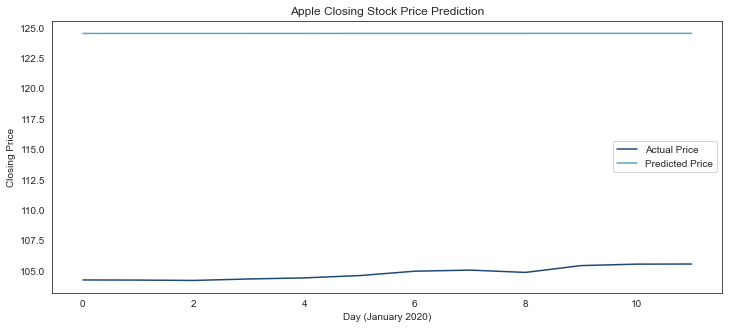

In [666]:
plt.figure(figsize = (12, 5))
plt.plot(scaler.inverse_transform(test), label='Actual Price')
plt.plot(scaler.inverse_transform(preds), label='Predicted Price')
plt.title('Apple Closing Stock Price Prediction')
plt.xlabel('Day (January 2020)')
plt.ylabel('Closing Price')
plt.legend();